In [1]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

In [2]:
pd_start = datetime.datetime(2020, 3, 11).date()           # who declares start of pandemic
pd_days = (datetime.datetime.now().date() - pd_start).days # number of days since start of pandemic
q_days = 10

In [3]:
# VT COVID-19 Cases by County Time Series
# https://geodata.vermont.gov/datasets/vt-covid-19-cases-by-county-time-series
covid_by_county_endpoint = "https://services1.arcgis.com/BkFxaEFNwHqX3tAw/arcgis/rest/services/VIEW_EPI_CountyDailyCountTS_PUBLIC/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36'
}

In [4]:
def get_date(esri_datestamp):
    a_datetime = datetime.datetime.fromtimestamp(esri_datestamp / 1000)
    return datetime.datetime.date(a_datetime)

In [5]:
def get_data(api_url):
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    response = session.get(api_url, headers=headers)

    return response.text

In [6]:
covid_data = json.loads(get_data(covid_by_county_endpoint))

In [7]:
daily_data = []
for feature in covid_data["features"]:
    daily_data.append(feature["attributes"])

In [8]:
df_covid = pd.DataFrame(daily_data)
df_covid['date'] = df_covid['date'].map(get_date)
df_covid

,OBJECTID,date,map_county,CNTYGEOID,C_New,C_Total,D_New,D_Total,OBJECTID_1,T_Total
0,923890,2020-03-07,Addison County,50001,0,0,0,0,1,2
1,923891,2020-03-07,Bennington County,50003,1,1,0,0,2,2
2,923892,2020-03-07,Caledonia County,50005,0,0,0,0,3,1
3,923893,2020-03-07,Chittenden County,50007,0,0,0,0,4,1
4,923894,2020-03-07,Orange County,50017,0,0,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...
5073,928963,2021-02-10,Pending Validation,99999,1,9,0,0,5074,28236
5074,928964,2021-02-10,Rutland County,50021,17,1109,0,9,5075,25247
5075,928965,2021-02-10,Washington County,50023,12,1314,0,12,5076,28767
5076,928966,2021-02-10,Windham County,50025,3,847,0,11,5077,18706


In [9]:
df_bennington = df_covid[df_covid['map_county'].str.contains('Bennington County')]
df_chittenden = df_covid[df_covid['map_county'].str.contains('Chittenden County')]

In [10]:
pos_cases_avg_bennington = df_bennington.C_New.rolling(7).mean()
pos_cases_avg_chittenden = df_chittenden.C_New.rolling(7).mean()
active_cases_est = df_bennington.C_New.rolling(q_days).sum()

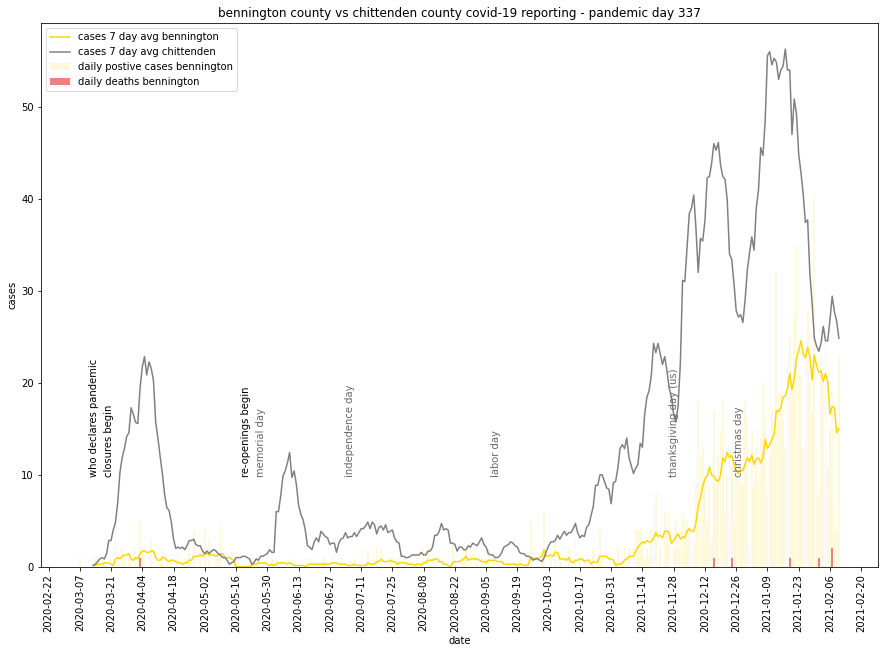

In [11]:
plt.figure(figsize=[15,10])
plt.grid(False)

# plot data
plt.plot(df_bennington.date, pos_cases_avg_bennington, label='cases 7 day avg bennington', color="gold")
plt.plot(df_bennington.date, pos_cases_avg_chittenden, label='cases 7 day avg chittenden', color="gray")
plt.bar(df_bennington.date, df_bennington.C_New, label='daily postive cases bennington', color="cornsilk")
# plt.plot(df_bennington.date, active_cases_est, label='est active cases', color="orange")
plt.bar(df_bennington.date, df_bennington.D_New, label='daily deaths bennington', color='lightcoral')

# axis formatting
plt.xlabel("date")
plt.ylabel("cases")

# space date ticks two weeks apart
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.xticks(rotation=90)

# title and annotations
plt.title("bennington county vs chittenden county covid-19 reporting - pandemic day " + str(pd_days) )
plt.text(datetime.datetime(2020, 3, 11), 10, "who declares pandemic", rotation=90)
plt.text(datetime.datetime(2020, 3, 18), 10, "closures begin", rotation=90)
plt.text(datetime.datetime(2020, 5, 18), 10, "re-openings begin", rotation=90)
plt.text(datetime.datetime(2020, 5, 25), 10, "memorial day", rotation=90, color='dimgrey')
plt.text(datetime.datetime(2020, 7, 4), 10, "independence day", rotation=90, color='dimgrey')
plt.text(datetime.datetime(2020, 9, 7), 10, "labor day", rotation=90, color='dimgrey')
plt.text(datetime.datetime(2020, 11, 26), 10, "thanksgiving day (us)", rotation=90, color='dimgrey')
plt.text(datetime.datetime(2020, 12, 25), 10, "christmas day", rotation=90, color='dimgrey')
plt.legend(loc=2)